# Simulating CIR Process

### Theoretical setup

We consider the CIR process: 

$dX_t=\kappa(\theta-X_t)dt+\sigma\sqrt{X_t}dW_t$, where $W_t$ is a standard Brownian Motion, $dW_t\sim N(0, dt)$.

The CIR process stays positive as long as we have the Feller condition, $\sigma^2\leq2\theta\kappa$ satisfied.
We consider the CIR process with parameters $X_0=0.05,\;\kappa=1,\;\theta=0.05,\;\sigma=\sqrt{2\theta\kappa}$ and we simulate on $\left[0,T\right]\;\text{for}\;T=10$ with discrete step size $\Delta t=\frac{1}{Tx365}$ for the daily rates.
We use $M=100$ Monte Carlo sample paths.

In simulating the CIR process, we consider three schemes:

1. Modified Euler Scheme (to enforce a real value): $X_{i+1}=(1-\kappa\Delta t)X_i+\kappa\theta\Delta t + \sigma\sqrt{X_i^+}\Delta W_i$


2. Milstein Scheme: $X_{i+1}=(1-\kappa\Delta t)X_i+\kappa\theta\Delta t + \sigma\sqrt{X_i}\Delta W_i + \frac{\sigma^2}{4}(\Delta W_i^2-\Delta t)$


3. Implicit Scheme: $X_{i+1}=\left(\frac{\sigma\Delta W_i+\sqrt{\sigma^2\Delta W_i^2+4\left(\left(1-\kappa\Delta t\right)X_i+\left(\kappa\theta-\frac{\sigma^2}{2}\right)\Delta t\right)}}{2}\right)^2$

The implicit scheme is derived drom the SDE constructed from the forward Euler (Stratanovich-type) approximation. First, by applying Ito's lemma to $\sqrt{X_t} $ we obtain: 

$dX_t = \frac{1}{X_t}\left(\frac{\kappa\left(\theta-X_t\right)}{2}-\frac{\sigma^2}{8}\right)dt+\frac{\sigma}{2}dW_t$

Next, we discretize the SDE for the CIR process,

$X_{i+1}=X_i+\kappa(\theta-X_i)\Delta t + \sigma\sqrt{X_i}\Delta W_i$,

and then change $\sqrt{X_i}$ to $\sqrt{X_{i+1}}$ using Ito's lemma for $\sqrt{X_t}$:

$X_{i+1}=X_i+\kappa(\theta-X_i)\Delta t +\sigma\sqrt{X_i}\Delta W_i $

$=X_i+\kappa(\theta-X_i)\Delta t +\sigma\underbrace{\left(\sqrt{X_i}-\sqrt{X_{i+1}}\right)\Delta W_i }_ {\approx -\frac{\sigma}{2}\Delta t}+\sigma\sqrt{X_{i+1}}\Delta W_i\implies$

$X_{i+1}=X_i+\left(\kappa\theta-\frac{\sigma^2}{2}-\kappa X_i\right)\Delta t+\sigma\sqrt{X_{i+1}}\Delta W_i+ \text{h.o.t}$,

where h.o.t stands for higher-order terms. If we neglect h.o.t, then we have an implicit scheme, where $\sqrt{X_{i+1}}$ is found by solving a quadratic equation at each time step,

$\sqrt{X_{i+1}}=\frac{\sigma \Delta W_i+\sqrt{\sigma^2 \Delta W_i^2+4\left(\left(1-\kappa \Delta t\right)X_i+\left(\kappa \theta-\frac{\sigma^2}{2} \right)\Delta t\right)}}{2}$.

The discriminant is real valued so long as $\Delta t $ is small enough such that $1-\kappa \Delta t >0$, and so long as we have the Feller condition in place, i.e., $\sigma^2\leq 2 \kappa\theta$.
In this case, we are ensured that no coplex numbers occur in the implicit scheme, and thus that$X_{i+1}\geq0$.



### Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [2]:
# Initial Parameters
X0 = 0.05
k = 1
theta = 0.05
sigma = sqrt(2 * theta * k)
T = 10
n = 365 *T # Day intervals
dt = T/n
M = 100 # Monte Carlo samples

# Create a multivariate Standard Brownian Motion to use in the simulations
dW = np.random.normal(0, 1, (M,n)) * sqrt(dt)
dW.shape

(100, 3650)

### Modified Euler Scheme:

In [3]:
# Initial vectorization
X_euler = X0 * np.ones((M,n))
# Loop over each time node and fill the Monte Carlo paths at each node
for j in range(1, X_euler.shape[1]):
    X_euler[:, j] = (1 - k * dt) * X_euler[:, j - 1] + (k * theta * dt) + sigma * np.sqrt(np.maximum(X_euler[:, j - 1], 0))* dW[:, j - 1 ]

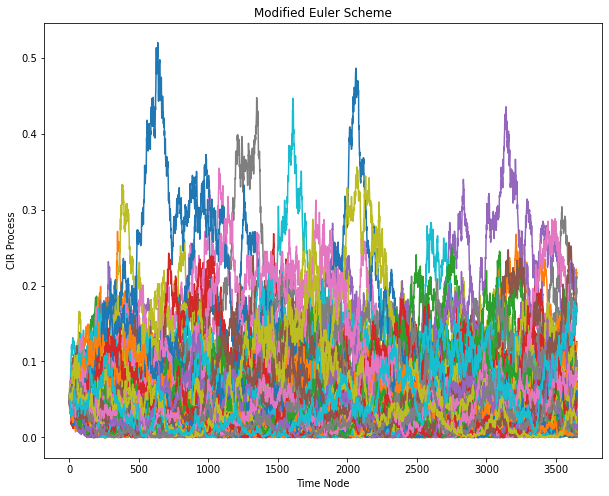

In [4]:
# Visualize the paths
plt.figure(figsize=(10,8))
plt.plot(X_euler.T)
plt.title("Modified Euler Scheme")
plt.ylabel("CIR Process")
plt.xlabel("Time Node")
plt.show()

In [5]:
# Average number of times per sample path that the simulated process hits a negative number
average_negative_per_path = np.sum(X_euler < 0, axis=1).mean()
print(f"The Modified-Euler scheme hits negative value an average of {average_negative_per_path} times per sample path.")

The Modified-Euler scheme hits negative value an average of 4.68 times per sample path.


### Milstein Scheme

In [6]:
# Initial Vectorization
X_milstein = X0 * np.ones((M,n))
# Loop over each time node and fill the Monte Carlo paths at each node
for j in range(1, X_milstein.shape[1]):
    X_milstein[:, j] = (1 - k * dt) * X_milstein[:, j - 1] + (k * theta * dt) + sigma * np.sqrt(X_milstein[:, j - 1])* dW[:, j - 1 ] + (sigma**2 / 4) * (dW[:, j -1]**2 - dt)

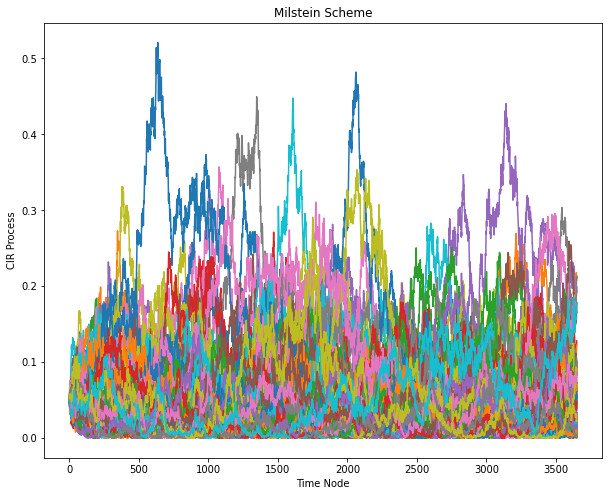

In [7]:
# Visualize the paths
plt.figure(figsize=(10,8))
plt.plot(X_milstein.T)
plt.title("Milstein Scheme")
plt.ylabel("CIR Process")
plt.xlabel("Time Node")
plt.show()

In [8]:
# Average number of times per sample path that the simulated process hits a negative number
average_negative_per_path = np.sum(X_milstein < 0, axis=1).mean()
print(f"The Milstein scheme hits negative value an average of {average_negative_per_path} times per sample path.")

The Milstein scheme hits negative value an average of 0.0 times per sample path.


### Implicit Scheme

In [9]:
# Initial Vectorization
X_implicit = X0 * np.ones((M,n))
# Loop over each time node and find the value of the process by solving a quadratic equation
for j in range(1, X_implicit.shape[1]):
    # The coefficients of the quadratic equation at each time node are:
    a = 1
    b = -sigma * dW[:, j]
    c = -(1 - k * dt) * X_implicit[:, j - 1] - (k * theta - 0.5 * sigma**2) * dt
    discriminant = b**2 - 4 * a * c
    root = (-b + np.sqrt(discriminant)) / (2 * a)
    # Set the value of the process
    X_implicit[:, j] = root**2

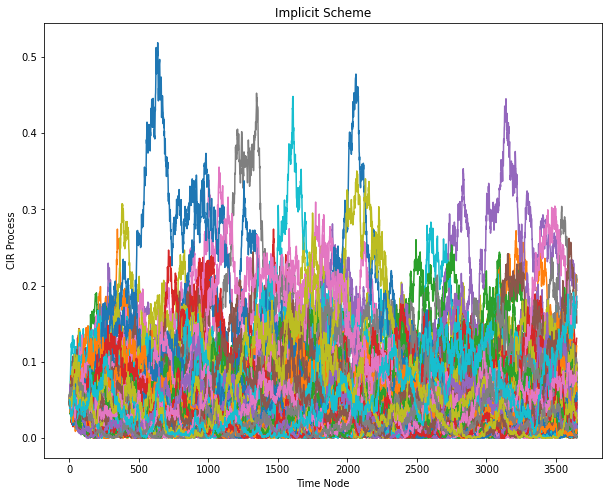

In [10]:
# Visualize the paths
plt.figure(figsize=(10,8))
plt.plot(X_implicit.T)
plt.title("Implicit Scheme")
plt.ylabel("CIR Process")
plt.xlabel("Time Node")
plt.show()

In [11]:
# Average number of times per sample path that the simulated process hits a negative number
average_negative_per_path = np.sum(X_implicit < 0, axis=1).mean()
print(f"The Milstein scheme hits negative value an average of {average_negative_per_path} times per sample path.")

The Milstein scheme hits negative value an average of 0.0 times per sample path.


The Milstein and Implicit schemes never hit negative values, however the Modified-Euler scheme hits a negative value of about 6 times per Monte Carlo sample path.